<a href="https://colab.research.google.com/github/giardinas-dev/awesome-pytorch-neural-networks/blob/main/rete_neurale_per_il_settore_food.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import os
import random

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import confusion_matrix
import seaborn as sns
import json
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset


In [ ]:
# Random seed for reproducibility
seed = 37

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [ ]:
import requests
import zipfile
import io
import os


url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip'
zip_filename = 'dataset_food'


if not os.path.exists(zip_filename):
    print("File ZIP non trovato. Scaricamento in corso...")
    response = requests.get(url)
    response.raise_for_status()
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
      for file_name in zip_ref.namelist():
          print(file_name)
      zip_ref.extractall('dataset_food')



Output streaming troncato alle ultime 5000 righe.
dataset/train/omelette/582339_43563ec9bb144f60866003fdde13591d.jpg
dataset/train/omelette/582525_1d6397f338bd4c7ab1b86b4d6414f0f7.jpg
dataset/train/omelette/2930618_18106524b6f64adf805c732176c000ea.jpg
dataset/train/omelette/84313_32b6136cb7bd47e58805b580b781cb17.jpg
dataset/train/omelette/3415929_7c4dd9417da141ecbee09381d142d3d1.jpg
dataset/train/omelette/2081062_eb523a3ad4b9470fb598dcf785b73063.jpg
dataset/train/omelette/1938551_b908c7a56ece460f812bc5bad143d14e.jpg
dataset/train/omelette/993789_3bba73a90dbf42af84d04a27faddb284.jpg
dataset/train/omelette/1063810_e8b94da9e961441b89b25d25dca9c600.jpg
dataset/train/omelette/1825409_613c50e92f9f421d9ad1ba210a8b72db.jpg
dataset/train/omelette/2609473_177eb3c969ec4ed0853690ee59e81863.jpg
dataset/train/omelette/2367734_0d154a38996c4b1bbfebdb425c9b14b7.jpg
dataset/train/omelette/2048075_3ff5a38058954cd6974cef86c5aed0a2.jpg
dataset/train/omelette/3767438_ede5ee3ac96c4b2c91e7bcefa101b2ba.jpg
dat

In [ ]:
def stratified_subset(dataset, ratio, seed=37):

    targets = dataset.targets
    sss = StratifiedShuffleSplit(n_splits=1, test_size=ratio, random_state=seed)
    indices = list(range(len(dataset)))
    for reduced_idx, _ in sss.split(indices, targets):
        break
    return Subset(dataset, reduced_idx)

**PREPROCESSING**

Dato il task di classificazione nel settore food, si è applicato un ridimensionamento a 256×256 pixel per ogni immagine cosi da uniformare l’input ai modelli, seguito da una normalizzazione rispetto a media e deviazione standard (0.5, 0.5, 0.5), compatibile con modelli pre-addestrati su ImageNet.

**SOTTOCAMPIONAMENTO**

È stato inoltre effettuato estratto un sotto-campione stratificato del 20% per ciascun set (train, val, test), al fine di ridurre i tempi di training e validazione mantenendo il bilanciamento tra classi.

Per verificare visivamente le trasformazioni applicate, è stata utilizzata una funzione di conversione (*tensor_to_image*) che ripristina l’immagine normalizzata in un formato RGB visualizzabile con *matplotlib*.



**DATA AUGMENTATION**

Considerata la natura del dataset, composto da immagini di cibi con una certa variabilità visiva ma strutturalmente simili, si è optato per una data augmentation leggera ma efficace. In particolare, sono stati introdotti un flip orizzontale casuale (*p=0.5*) e una variazione randomica di luminosità e contrasto (*p=0.2*), in modo da simulare diverse condizioni di illuminazione e angolazioni di scatto, senza alterare in modo significativo il contenuto semantico delle immagini. Questa strategia è stata utile per aumentare la varietà dei dati e migliorare la capacità di generalizzazione dei modelli.

In [ ]:
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ToTensorV2(),
])

transform_augmentation = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ToTensorV2(),
])


batch_size = 64

trainset = torchvision.datasets.ImageFolder(root='dataset_food/dataset/train', transform=Transforms(transform_augmentation))
classes = trainset.classes
# Riduce il dataset di training mantenendo la distribuzione delle classi
trainset = stratified_subset(trainset,0.8) # riduce dell'80% il dataset originale

valset = torchvision.datasets.ImageFolder(root='dataset_food/dataset/val', transform=Transforms(transform))
valset = stratified_subset(valset,0.8)

testset = torchvision.datasets.ImageFolder(root='dataset_food/dataset/test',transform=Transforms(transform))
testset = stratified_subset(testset,0.8)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=False)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)


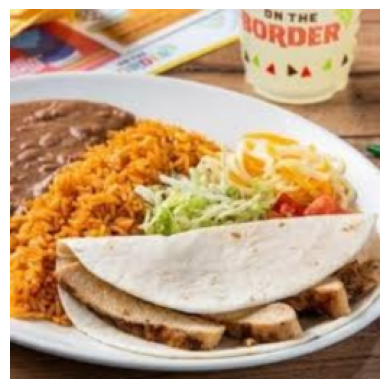

In [ ]:
def tensor_to_image(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

plt.imshow(tensor_to_image(trainset[89][0]))
plt.axis('off')
plt.show()


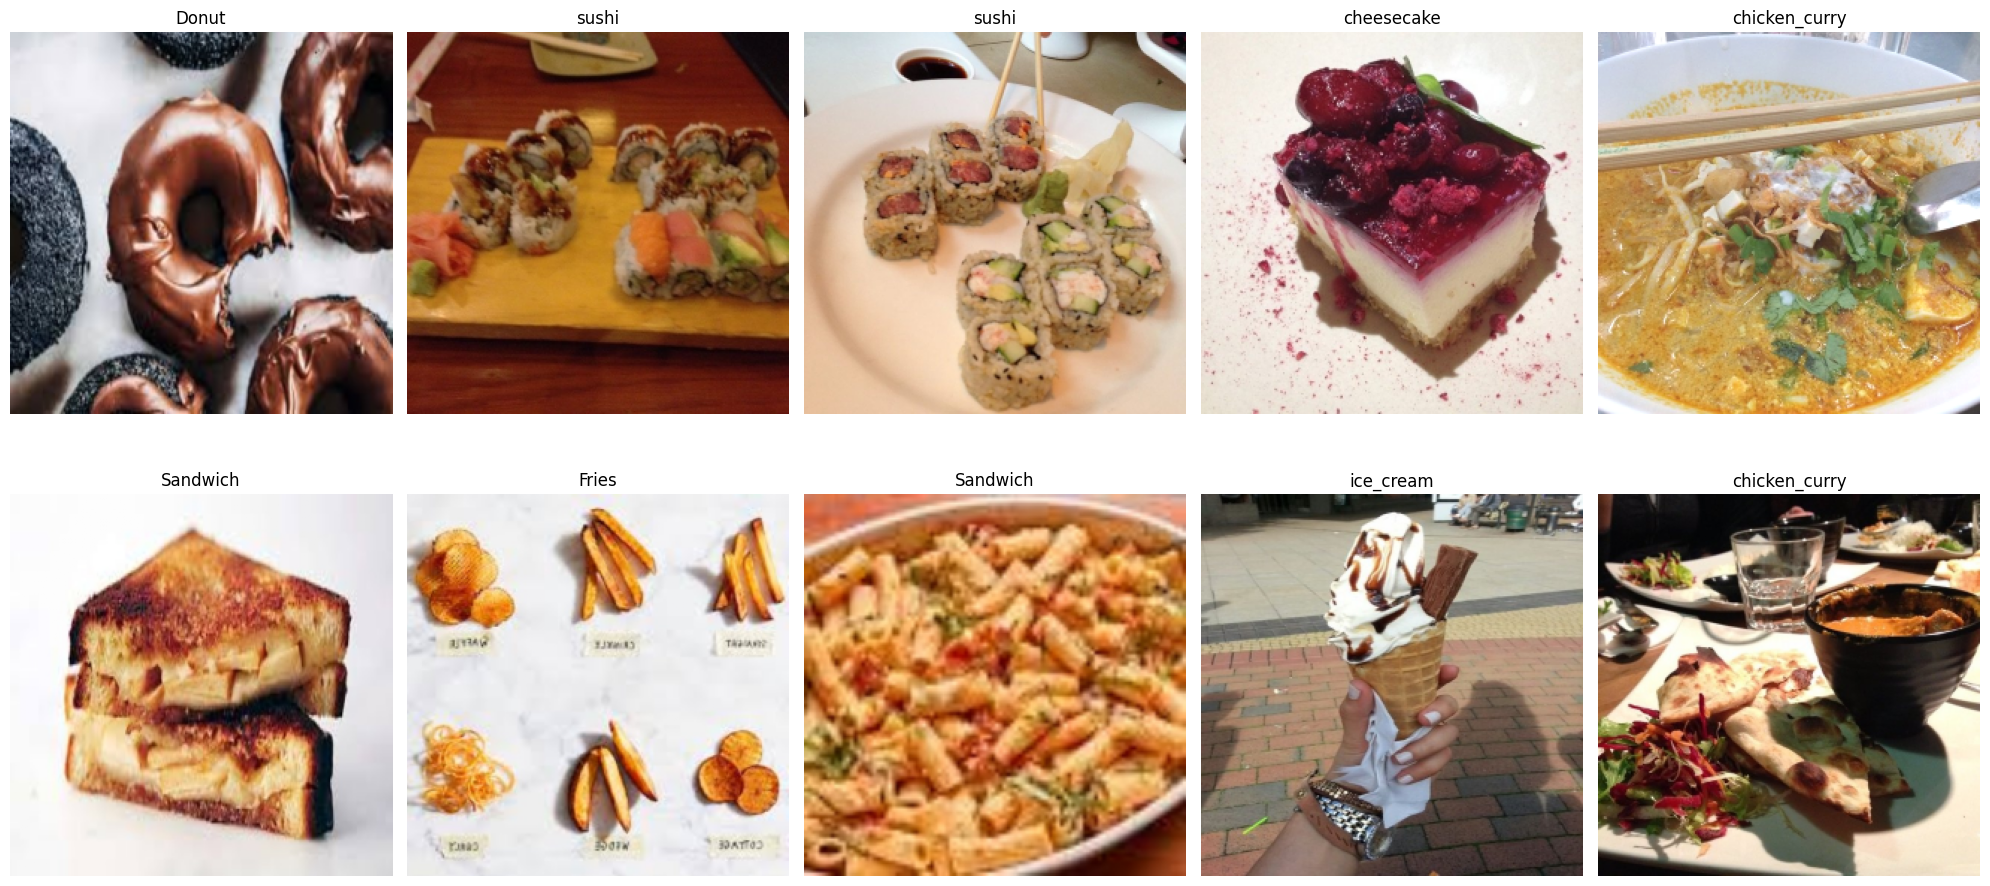

In [ ]:
# # Visualizzazione di un campione casuale di immagini dal dataset di addestramento (trainset)
#  2 righe per 5 colonne di immagini (totale 10 immagini)

num_row = 2
num_col = 5
iteration =np.random.randint(0, len(trainset)-10)
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(tensor_to_image(trainset[iteration + i][0]))
    ax.axis('off')
    ax.set_title('{}'.format(classes[int(trainset[iteration + i][1])]))
plt.tight_layout()
plt.show()




SCELTA DEL MODELLO

Per il task di classificazione con 14 classi, sono stati scelti modelli convoluzionali pre-addestrati su ImageNet e adattati tramite classificatori custom per il fine-tuning. La selezione dei modelli è stata guidata dall’obiettivo di bilanciare accuratezza, complessità computazionale e dimensione del modello.

I modelli considerati sono:

*VGG16*: variante con diverse configurazioni di dropout e dimensioni del fully connected layer, utile per studiare l’impatto della regolarizzazione e della capacità rappresentativa.

*ResNet50*: architettura profonda con feature extractor più robusto e compatto, dotato di un layer finale semplice, adatto a gestire complessità di pattern.

*MobileNetV2*: modello leggero e efficiente, con dropout e fully connected di dimensioni maggiori per migliorare la capacità di generalizzazione mantenendo l’efficienza.

*SqueezeNet*: modello molto compatto, con architettura minimalista e fully connected lineare, utile per scenari a risorse computazionali limitate.

I modelli sono stati implementati con la possibilità di congelare il backbone per modalità di tuning più veloci o di sbloccare l’intera rete per un adattamento più approfondito

IPERPARAMETRI

Per ottimizzare la sperimentazione, sono state definite due modalità di tuning:

Modalità *deep*: include un set più ampio di modelli, ottimizzatori (Adam e SGD con diversi learning rate) e un numero maggiore di epoche (30,50 e 100), per una ricerca esaustiva di configurazioni e performance. Questa modalità consente di analizzare in dettaglio l’effetto di dropout, dimensione del fully connected e scelta dell’ottimizzatore sul training.

Modalità *easy*: riduce il numero di modelli (solo VGG senza dropout, VGG con dropout 0.3 e ResNet50, SqueezeNet), gli ottimizzatori (Adam e SGD con lr=1e-3) e abbassa le epoche (20) per accelerare il training e la valutazione. Questa configurazione è utile per prove preliminari o test rapidi su risorse computazionali limitate.

In [ ]:
## MODALITA DI TUNING
##
# Modalità di tuning: 'deep' per ricerca completa, 'easy' per ricerca rapida
# Analisi errori effettuata con tuning deep
#
mode = 'easy'  # cambiare in 'easy' per la ricerca rapida

# mode deep circa 2 ore con L4 GPU
# mode easy 30/40 min con L4 GPU
# dettagli modalità piu in basso ↓↓↓

In [ ]:


class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.min_val_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_epoch = None  # Epoca del miglior modello
        self.trainer = None



    def reset(self):
        self.min_val_loss = None
        self.counter = 0
        self.early_stop = False
        self.best_epoch = None
        self.early_stop = False


    def __call__(self, validation_loss, model, epoch = None):
        if self.min_val_loss is None:
            self.min_val_loss = validation_loss
            self.save_checkpoint()
            self.best_epoch = epoch

        elif (self.min_val_loss - validation_loss) > self.min_delta:  # Miglioramento
            self.min_val_loss = validation_loss
            self.save_checkpoint()
            self.counter = 0
            self.best_epoch = epoch


        else:  # Nessun miglioramento
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                print(f"Modello salvato in {self.trainer.get_path()}")


    def save_checkpoint(self):
      self.trainer.save_model_and_log()



**CLASSE *TRAINER***

La classe Trainer è pensata per gestire in modo completo e modulare l’addestramento e la validazione di modelli PyTorch. Supporta il training su batch, l’uso di diversi ottimizzatori, early stopping, e il monitoraggio di metriche come loss e accuratezza. Include funzioni per salvare i modelli, visualizzare grafici di performance e analizzare errori tramite matrici di confusione, rendendola uno strumento flessibile per sperimentazioni sul task di classificazione.

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm


class Trainer:
    def __init__(self, model, name, criterion, device, train_loader, val_loader, classes=None, early_stopping=None, logger = None):
        self.model = model.to(device)
        self.name = name
        self.criterion = criterion
        self.device = device
        self.classes = classes
        self.train_loader = train_loader
        self.test_loader = val_loader

        self.optimizer = None
        self.optimizer_name = None


        self.logger = logger
        self.last_training_info = None



    def set_early_stopping(self, early_stopping):
        self.early_stopping = early_stopping
        self.early_stopping.trainer = self

    def set_optimizer(self, optimizer, name):
        self.optimizer = optimizer
        self.optimizer_name = name
    def train_epoch(self,optimizer = None):
        if optimizer is None:
          optimizer = self.optimizer
        self.model.train()
        running_loss = 0.0
        processed_data = 0
        for data in tqdm(self.train_loader,desc='Train_epoch in progress'):
            inputs, labels = data[0].to(self.device), data[1].to(self.device)
            optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()*inputs.size(0)
            processed_data += len(inputs)

        return running_loss / processed_data

    def test_epoch(self, test_loader=None):
        if test_loader is None:
            test_loader = self.test_loader
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(test_loader,desc='Test_epoch in progress'):
                inputs, labels = data[0].to(self.device), data[1].to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()*inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        return running_loss / total, correct / total

    def final_test_accuracy(self, test_loader=None):
      if test_loader is None:
          test_loader = self.test_loader

      self.model.eval()
      correct = 0
      total = 0

      with torch.no_grad():
          for inputs, labels in test_loader:
              inputs = inputs.to(self.device)
              labels = labels.to(self.device)
              outputs = self.model(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      accuracy = correct / total
      self.last_training_info['final_accuracy'] = accuracy
      return accuracy


    def train(self, test_loader=None, epochs=100, experiment_name=None, optimizer=None):

        if self.early_stopping is not None:
            self.early_stopping.reset()
        if optimizer is None:
            optimizer = self.optimizer
        if self.optimizer is None and optimizer is None:
            raise ValueError("Optimizer not set. Use set_optimizer() before training.")

        if test_loader is None:
            test_loader = self.test_loader

        train_losses = []
        val_losses = []
        val_accuracies = []
        best_epoch = None

        for epoch in tqdm(range(epochs), desc="Training Progress"):

            train_loss = self.train_epoch(optimizer)
            val_loss, val_accuracy = self.test_epoch(test_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            tqdm.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

            if self.early_stopping is not None:
                self.early_stopping(val_loss, self.model, epoch)
                if self.early_stopping.early_stop:
                    best_epoch =  self.early_stopping.best_epoch
                    print("Early stopping")
                    break

        epochs_run = epoch + 1
        if experiment_name is None:
            experiment_name = f"experiment_{len(self.logger.get_all())+ 1}"



        exp_record = {
            "experiment_name": experiment_name,
            "optimizer": self.optimizer_name,
            "criterion": type(self.criterion).__name__,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies,
            "epochs_run": epochs_run,
            "best_epoch_early_stopping": best_epoch,
        }
        self.logger.log(exp_record)

        self.last_training_info = exp_record
        if not self.early_stopping.early_stop:
            self.save_model_and_log()
            print(f"Model salvato in {self.name}/model.pt")
        self.early_stopping.reset()
        self.save_model_and_log(log_filename = f"log_{experiment_name}.json", log_data = exp_record)

        return train_losses, val_losses, val_accuracies, epochs_run, best_epoch


    def plot_accuracies(self):
        plt.figure(figsize=(10, 6))
        colors = plt.cm.get_cmap('tab10')
        for i,exp in enumerate(self.logger.get_all()):
            color = colors(i % 10)
            epochs = range(1, exp["epochs_run"] + 1)
            plt.plot(epochs, exp["val_accuracies"], label=f'Val Accuracy ({exp["optimizer"]}-Epoche:{exp["epochs_run"]})',color=color)

            # Linea verticale miglior val accuracy (best_epoch)
            if exp.get("best_epoch_early_stopping") is not None:
                plt.axvline(exp["best_epoch_early_stopping"] + 1, color=color, linestyle='--', alpha=0.7,
                            label=f'Best Val Accuracy Epoch - ({exp["optimizer"]}-Epoche:{exp["best_epoch_early_stopping"]})')



        plt.xlabel("Epochs")
        plt.ylabel("Validation Accuracy")
        plt.title(f"{self.name} - Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_losses_bar(self):
        experiment_names = []
        train_losses = []
        val_losses = []

        for i, exp in enumerate(self.logger.get_all()):
            name = f"{exp['optimizer']}-Epochs:{exp['epochs_run']}"
            experiment_names.append(name)

            best_epoch = exp.get("best_epoch_early_stopping")
            if best_epoch is not None:
                train_losses.append(exp["train_losses"][best_epoch])
                val_losses.append(exp["val_losses"][best_epoch])
            else:
                train_losses.append(exp["train_losses"][-1])
                val_losses.append(exp["val_losses"][-1])

        x = range(len(experiment_names))
        width = 0.35

        plt.figure(figsize=(12, 6))
        plt.bar([xi - width/2 for xi in x], train_losses, width=width, label="Train Loss", color="skyblue")
        plt.bar([xi + width/2 for xi in x], val_losses, width=width, label="Val Loss", color="salmon")

        plt.xticks(x, experiment_names, rotation=45, ha="right")
        plt.ylabel("Loss")
        plt.title(f"{self.name} - Best Train/Validation Loss ")
        plt.legend()
        plt.tight_layout()
        plt.grid(axis="y", linestyle="--", alpha=0.5)
        plt.show()




    def get_last_training_info(self):
          print("="*50)
          print(f"Experiment Summary: {self.last_training_info.get('experiment_name', 'N/A')}")
          print("-"*50)
          print(f"Optimizer:           {self.last_training_info.get('optimizer', 'N/A')}")
          print(f"Criterion:           {self.last_training_info.get('criterion', 'N/A')}")
          print(f"Epochs Run:          {self.last_training_info.get('epochs_run', 'N/A')}")
          print(f"best_epoch_early_stopping: {self.last_training_info.get('best_epoch_early_stopping', 'N/A')}")
          print("-"*50)
          print(f"Final Training Loss: {self.last_training_info['train_losses'][-1]:.4f}")
          print(f"Final Validation Loss: {self.last_training_info['val_losses'][-1]:.4f}")
          print(f"Final Validation Accuracy: {self.last_training_info['final_accuracy']:.4f}")
          print("="*50)
          return self.last_training_info



    def plot_confusion_matrix(self, test_loader=None):
            if test_loader is None:
                test_loader = self.test_loader
            self.model.eval()
            y_true = []
            y_pred = []

            with torch.no_grad():
                for i, data in enumerate(test_loader, 0):
                    inputs, labels = data[0].to(self.device), data[1].to(self.device)
                    outputs = self.model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())

            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(10,7))
            sns.heatmap(cm, annot=True, fmt='d', xticklabels=self.classes, yticklabels=self.classes, cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            title = f" \n {model_name} with {opt_name} optimizer for {epochs} epochs"
            plt.title(f"Confusion Matrix: {title} \n", color='blue')
            plt.show()

    def save_model_and_log(self, model_filename="model.pt", log_filename=None, log_data=None):
            folder = os.path.join("models", self.name)
            os.makedirs(folder, exist_ok=True)

            model_path = os.path.join(folder, model_filename)




            if log_filename is not None and log_data is not None:
                log_path = os.path.join(folder, log_filename)
                with open(log_path, 'w') as f:
                    json.dump(log_data, f, indent=4)
                print(f"Log salvato in: {log_path}")
            else:
              torch.save(self.model.state_dict(), model_path)



    def load_model(self, model_filename="model.pt"):
            model_path = os.path.join("models", self.name, model_filename)
            if os.path.isfile(model_path):
                self.model.load_state_dict(torch.load(model_path, map_location=self.device))
                self.model.to(self.device)
                print(f"Modello caricato da: {model_path}")
            else:
                print(f"File non trovato: {model_path}")

    def get_path(self):
            return "models/"+self.name

    def show_errors(self, test_loader=None, max_errors=10):
            if test_loader is None:
                test_loader = self.test_loader
            self.model.eval()

            all_wrong_images = []
            all_true_labels = []
            all_pred_labels = []

            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(inputs)
                    _, preds = torch.max(outputs, 1)

                    wrong_idxs = (preds != labels).nonzero(as_tuple=False).squeeze()
                    if wrong_idxs.dim() == 0 and wrong_idxs.numel() > 0:
                        wrong_idxs = wrong_idxs.unsqueeze(0)

                    for idx in wrong_idxs:
                        all_wrong_images.append(inputs[idx].cpu())
                        all_true_labels.append(labels[idx].item())
                        all_pred_labels.append(preds[idx].item())

            if len(all_wrong_images) > max_errors:
                selected_idxs = random.sample(range(len(all_wrong_images)), max_errors)
            else:
                selected_idxs = range(len(all_wrong_images))

            plt.figure(figsize=(15, 8))
            for i, idx in enumerate(selected_idxs):
                plt.subplot(2, 5, i + 1)
                plt.imshow(tensor_to_image(all_wrong_images[idx]))
                true_label = self.classes[all_true_labels[idx]] if self.classes else all_true_labels[idx]
                pred_label = self.classes[all_pred_labels[idx]] if self.classes else all_pred_labels[idx]
                plt.title(f"True: {true_label}\nPred: {pred_label}")
                plt.axis('off')

            plt.show()

## Il codice delle funzioni relative all'implementazione dei grafici/ errori è stato realizzato in parte con l'aiuto di chat-GPT.

**MODELLI**

Queste classi implementano diversi classificatori basati su backbone pre-addestrati (VGG16, ResNet, MobileNet, SqueezeNet), personalizzando l'ultima parte con layer fully connected per adattarli a specifici compiti di classificazione.

Ogni modello offre metodi per congelare i pesi del backbone (per evitare aggiornamenti durante il training) e per contare i parametri addestrabili, utili per gestire l’ottimizzazione e la complessità del modello.

In [ ]:
class VGGClassifier(nn.Module):
    def __init__(self, vgg_backbone, in_features, num_classes , dropout,  hidden_input):
        super().__init__()
        self.features = vgg_backbone.features
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.fc = self.fc = nn.Sequential(
                      nn.Linear(in_features,  hidden_input),
                      nn.ReLU(),
                      nn.Dropout(dropout),
                      nn.Linear(hidden_input, num_classes)
         )
    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    def freeze_backbone(self):
        for param in self.features.parameters():
            param.requires_grad = False
    def count_trainable_params(self):
      return sum(p.numel() for p in self.parameters() if p.requires_grad)

class VGGClassifierNolayerFC(nn.Module):
    def __init__(self, vgg_backbone, in_features, num_classes):
        super().__init__()
        self.features = vgg_backbone.features
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_features, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    def freeze_backbone(self):
        for param in self.features.parameters():
            param.requires_grad = False
    def count_trainable_params(self):
      return sum(p.numel() for p in self.parameters() if p.requires_grad)

class ResNetClassifier(nn.Module):
    def __init__(self, resnet_backbone, in_features, num_classes):
        super().__init__()
        self.features = nn.Sequential(*list(resnet_backbone.children())[:-1])
        self.fc = nn.Linear(in_features, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    def freeze_backbone(self):
        for param in self.features.parameters():
            param.requires_grad = False
    def count_trainable_params(self):
      return sum(p.numel() for p in self.parameters() if p.requires_grad)

class MobileNetClassifier(nn.Module):
    def __init__(self, mobilenet_backbone, in_features, num_classes, hidden_input):
        super().__init__()
        self.features = mobilenet_backbone.features
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Sequential(
                      nn.Linear(in_features, hidden_input),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(hidden_input, num_classes)
         )
    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    def freeze_backbone(self):
        for param in self.features.parameters():
            param.requires_grad = False
    def count_trainable_params(self):
      return sum(p.numel() for p in self.parameters() if p.requires_grad)


class SqueezeNetClassifier(nn.Module):
    def __init__(self, squeezenet_backbone, in_features,  num_classes):
        super().__init__()
        self.features = squeezenet_backbone.features
        self.pooling = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_features, num_classes)
    def forward(self, x):
        x = self.features(x)
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
    def freeze_backbone(self):
        for param in self.features.parameters():
            param.requires_grad = False
    def count_trainable_params(self):
      return sum(p.numel() for p in self.parameters() if p.requires_grad)


**CLASSE *COMPARATOR***

La classe ModelComparer permette di gestire e confrontare facilmente più modelli di machine learning tenendo traccia delle loro configurazioni (nome modello, ottimizzatore, numero di epoche) e dei relativi risultati di training e validazione. Attraverso metodi dedicati, consente di registrare le metriche di performance come loss e accuracy, associandole a ciascun modello, e offre funzioni di visualizzazione per comparare graficamente l'andamento delle loss e dell’accuratezza nel corso delle epoche, evidenziando anche l’epoca con le migliori performance (early stopping).

In [ ]:

class ModelComparator:
    def __init__(self, name):
        self.models_logs = {}  # chiave = f"{model}_{optimizer}_{epochs}"
        self.name = name

    def add_model(self, model_name, optimizer_name, epochs):
        key = f"{model_name}_{optimizer_name}_{epochs}ep"
        self.models_logs[key] = {
            "model_name": model_name,
            "optimizer_name": optimizer_name,
            "epochs": epochs,
        }
        return key

    def results_model(self, key, train_losses, val_losses, val_accuracies, epochs_run, best_epoch):
       old_dict = self.models_logs[key]
       self.models_logs[key] ={
           "model_name": old_dict["model_name"],
           "optimizer_name": old_dict["optimizer_name"],
           "epochs": old_dict["epochs"],
           "train_losses": train_losses,
           "val_losses": val_losses,
           "val_accuracies": val_accuracies,
           "best_epoch": best_epoch,
           "epochs_run": epochs_run
       }



    def plot_loss_train(self):


        optimizers = set(log["optimizer_name"] for log in self.models_logs.values())
        epochs_list = set(log["epochs"] for log in self.models_logs.values())

        for optimizer in sorted(optimizers):
            for epochs in sorted(epochs_list):
                plt.figure(figsize=(12, 6))
                colors = plt.cm.get_cmap('tab10')
                plt.title(f"Train Loss - {optimizer} - {epochs} Epochs - {self.name}")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                i = 0
                for log in self.models_logs.values():
                    if log["optimizer_name"] == optimizer and log["epochs"] == epochs:
                        color = colors(i % 10)
                        i += 1
                        label = f"{log['model_name']} ({optimizer})"
                        plt.plot(range(1, len(log["train_losses"]) + 1), log["train_losses"], label=label, color = color)
                        if log["best_epoch"] is not None:
                          plt.axvline(log["best_epoch"], color=color, linestyle='--', alpha=0.7, label=f"{log['model_name']} stop best epoch {log['best_epoch']}")




                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()


    def plot_loss_validate(self):
        import matplotlib.pyplot as plt

        optimizers = set(log["optimizer_name"] for log in self.models_logs.values())
        epochs_list = set(log["epochs"] for log in self.models_logs.values())

        for optimizer in sorted(optimizers):
            for epochs in sorted(epochs_list):
                plt.figure(figsize=(12, 6))
                colors = plt.cm.get_cmap('tab10')
                plt.title(f"Validation Loss - {optimizer} - {epochs} Epochs - {self.name}")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                i = 0
                for log in self.models_logs.values():
                    if log["optimizer_name"] == optimizer and log["epochs"] == epochs:
                        color = colors(i % 10)
                        i += 1
                        label = f"{log['model_name']} ({optimizer})"
                        plt.plot(range(1, len(log["val_losses"]) + 1), log["val_losses"], label=label, color = color)
                        if log["best_epoch"] is not None:
                          plt.axvline(log["best_epoch"], color=color, linestyle='--', alpha=0.7, label=f"{log['model_name']} stop best epoch {log['best_epoch']}")



                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()

    def plot_accuracy(self):
        import matplotlib.pyplot as plt

        optimizers = set(log["optimizer_name"] for log in self.models_logs.values())
        epochs_list = set(log["epochs"] for log in self.models_logs.values())

        for optimizer in sorted(optimizers):
            for epochs in sorted(epochs_list):
                plt.figure(figsize=(12, 6))
                colors = plt.cm.get_cmap('tab10')
                plt.title(f"Validation Accuracy - {optimizer} - {epochs} Epochs - {self.name}")
                plt.xlabel("Epoch")
                plt.ylabel("Accuracy")
                i = 0
                for log in self.models_logs.values():
                    if log["optimizer_name"] == optimizer and log["epochs"] == epochs:
                        color = colors(i % 10)
                        i += 1
                        label = f"{log['model_name']} ({optimizer})"
                        plt.plot(range(1, len(log["val_accuracies"]) + 1), log["val_accuracies"], label=label,color = color)
                        if log["best_epoch"] is not None:
                          plt.axvline(log["best_epoch"], color=color, linestyle='--', alpha=0.7, label=f"{log['model_name']} stop best epoch {log['best_epoch']}")

                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()


In [ ]:
# La classe ExperimentLogger serve a registrare, salvare e consultare le informazioni
# relative agli esperimenti effettuati durante il training dei modelli.
# È utile per confrontare i risultati (es. loss, accuracy, parametri) tra diversi run
# e per tenere traccia delle configurazioni testate.

class ExperimentLogger:
    def __init__(self):
        self.experiments = []

    def log(self, experiment_info):
        self.experiments.append(experiment_info)

    def get_all(self):
        return self.experiments

    def last(self):
        return self.experiments[-1] if self.experiments else None

In [ ]:
from torchvision.models import vgg16, VGG16_Weights, resnet50, ResNet50_Weights, mobilenet_v2, MobileNet_V2_Weights, squeezenet1_0, SqueezeNet1_0_Weights
from torchsummary import summary


# definiamo il device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("MODELLI VALUTATI:\n\n")
print("\n\n Modello VGG16 \n\n")
vgg = vgg16(weights = VGG16_Weights.IMAGENET1K_V1).to(device)
summary(vgg, (3, 224, 224))

print("\n\n Modello RESNET50 \n\n")
resnet = resnet50(weights = ResNet50_Weights.IMAGENET1K_V2).to(device)
summary(resnet, (3, 224, 224))

print("\n\n Modello MOBILENET \n\n")
mobilenet = mobilenet_v2(weights = MobileNet_V2_Weights.IMAGENET1K_V1).to(device)
summary(mobilenet, (3, 224, 224))

print("\n\n Modello SQUEEZENET \n\n")
squeezenet = squeezenet1_0(weights = SqueezeNet1_0_Weights.IMAGENET1K_V1).to(device)
summary(squeezenet, (3, 224, 224))


MODELLI VALUTATI:




 Modello VGG16 




Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 227MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 234MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

100%|██████████| 13.6M/13.6M [00:00<00:00, 216MB/s]
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

100%|██████████| 4.78M/4.78M [00:00<00:00, 114MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 96, 109, 109]          14,208
              ReLU-2         [-1, 96, 109, 109]               0
         MaxPool2d-3           [-1, 96, 54, 54]               0
            Conv2d-4           [-1, 16, 54, 54]           1,552
              ReLU-5           [-1, 16, 54, 54]               0
            Conv2d-6           [-1, 64, 54, 54]           1,088
              ReLU-7           [-1, 64, 54, 54]               0
            Conv2d-8           [-1, 64, 54, 54]           9,280
              ReLU-9           [-1, 64, 54, 54]               0
             Fire-10          [-1, 128, 54, 54]               0
           Conv2d-11           [-1, 16, 54, 54]           2,064
             ReLU-12           [-1, 16, 54, 54]               0
           Conv2d-13           [-1, 64, 54, 54]           1,088
             ReLU-14           [-1, 64,

In [ ]:
# Definizione criterion e optimizer da settare per ogni modello
criterion = nn.CrossEntropyLoss()


# Per ottimizzare i tempi di training e rendere la sperimentazione più gestibile,
# si è scelto un sottoinsieme rappresentativo di modelli e ottimizzatori.
# Questa scelta consente un buon equilibrio tra varietà di architetture e parametri
# e la praticabilità computazionale, evitando un numero eccessivo di combinazioni
# che renderebbero la ricerca troppo lunga e complessa.





# Modalità di tuning: 'deep' per ricerca completa, 'easy' per ricerca rapida
# Analisi errori effettuata con tuning deep
#
# se vuoi cambiare modalità, cerca il blocco codice su con "mode=xxxx" ↑↑↑↑


if mode == 'deep':
    # Modalità deep: più modelli, ottimizzatori e epoche
    models = {
    "vgg_no_dropout": lambda: VGGClassifier(vgg16(weights='IMAGENET1K_V1'), 512, 14, 0, 512).to(device),
    "vgg_0_3drop": lambda: VGGClassifier(vgg16(weights='IMAGENET1K_V1'), 512, 14, 0.3, 512).to(device),
    "vgg_0_3drop_1024": lambda: VGGClassifier(vgg16(weights='IMAGENET1K_V1'), 512, 14, 0.3, 1024).to(device),
    "resnet": lambda: ResNetClassifier(resnet50(weights='IMAGENET1K_V2'), 2048, 14).to(device),
    "mobilenet_0_5drop_1024": lambda: MobileNetClassifier(mobilenet_v2(weights='IMAGENET1K_V1'), 1280, 14, 1024).to(device),
    "squeezenet": lambda: SqueezeNetClassifier(squeezenet1_0(weights='IMAGENET1K_V1'), 512, 14).to(device),
   #  "vgg_0_5drop_1024": lambda: VGGClassifier(vgg16(weights='IMAGENET1K_V1'), 512, 14, 0.5, 1024).to(device),
   # "vgg_nolayer": lambda: VGGClassifierNolayerFC(vgg16(weights='IMAGENET1K_V1'), 512, 14).to(device),
   #  "vgg_0_5drop": lambda: VGGClassifier(vgg16(weights='IMAGENET1K_V1'), 512, 14, 0.5, 512).to(device),
}


    optimizers = {
        "Adam_1e-3": lambda m: torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-4),
        "Adam_1e-4": lambda m: torch.optim.Adam(m.parameters(), lr=1e-4, weight_decay=1e-4),
        "SGD_1e-2": lambda m: torch.optim.SGD(m.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4),
        "SGD_1e-3": lambda m: torch.optim.SGD(m.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4),
        #"RMSprop_1e-3": lambda m: torch.optim.RMSprop(m.parameters(), lr=1e-3, weight_decay=1e-4),
    }

    epoch_list = [20, 40] # convergono tutte prima di 50

elif mode == 'easy':
    # Modalità easy: meno modelli, ottimizzatori e epoche per test veloci
    models = {
         "vgg_no_dropout": lambda: VGGClassifier(vgg16(weights='IMAGENET1K_V1'), 512, 14, 0, 512).to(device),
         "resnet": lambda: ResNetClassifier(resnet50(weights='IMAGENET1K_V2'), 2048, 14).to(device),
         #"vgg_0_3drop": lambda: VGGClassifier(vgg16(weights='IMAGENET1K_V1'), 512, 14, 0.3, 512).to(device),
         #"vgg_0_5drop_1024": lambda: VGGClassifier(vgg16(weights='IMAGENET1K_V1'), 512, 14, 0.5, 1024).to(device),
         "squeezenet": lambda: SqueezeNetClassifier(squeezenet1_0(weights='IMAGENET1K_V1'), 512, 14).to(device),

    }

    optimizers = {
        "Adam_1e-3": lambda m: torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-4),
        "SGD_1e-3": lambda m: torch.optim.SGD(m.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4),
    }

    epoch_list = [30]  # meno epoche per velocizzare

else:
    raise ValueError("Modalità sconosciuta. Usa 'deep' o 'easy'.")

# Ora puoi usare questi dizionari nel training loop
print(f"Modalità selezionata: {mode}")
print(f"Modelli usati: {list(models.keys())}")
print(f"Ottimizzatori usati: {list(optimizers.keys())}")
print(f"Epoche usate: {epoch_list}")

Modalità selezionata: easy
Modelli usati: ['vgg_no_dropout', 'resnet', 'squeezenet']
Ottimizzatori usati: ['Adam_1e-3', 'SGD_1e-3']
Epoche usate: [3]


 
Training model vgg_no_dropout with Adam_1e-3 optimizer for 3 epochs


Train_epoch in progress: 100%|██████████| 28/28 [00:11<00:00,  2.36it/s]

Training Progress:  33%|███▎      | 1/3 [00:14<00:29, 14.95s/it]

Epoch 1/3, Train Loss: 2.1416, Val Loss: 1.5749, Val Acc: 0.5938



Train_epoch in progress: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]

Training Progress:  67%|██████▋   | 2/3 [00:29<00:14, 14.97s/it]

Epoch 2/3, Train Loss: 1.2343, Val Loss: 1.0922, Val Acc: 0.7143



Train_epoch in progress: 100%|██████████| 28/28 [00:11<00:00,  2.35it/s]

Training Progress: 100%|██████████| 3/3 [00:44<00:00, 14.97s/it]


Epoch 3/3, Train Loss: 0.9066, Val Loss: 0.8980, Val Acc: 0.7545
Model salvato in vgg_no_dropout/model.pt
Log salvato in: models/vgg_no_dropout/log_experiment_1.json
Experiment Summary: experiment_1
--------------------------------------------------
Optimizer:           Adam_1e-3
Criterion:           CrossEntropyLoss
Epochs Run:          3
best_epoch_early_stopping: None
--------------------------------------------------
Final Training Loss: 0.9066
Final Validation Loss: 0.8980
Final Validation Accuracy: 0.7232


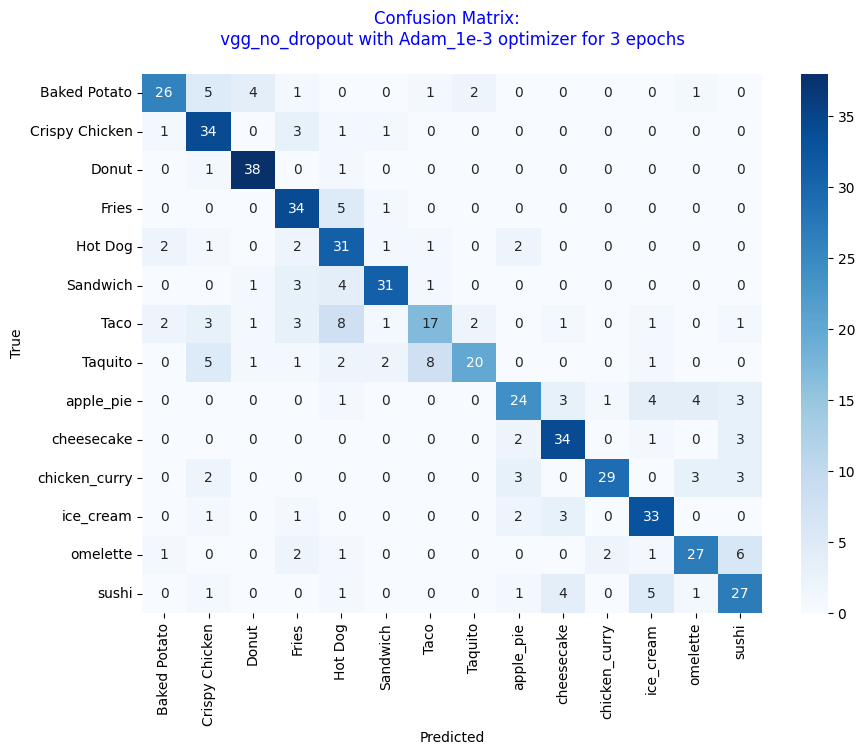

--------------------------------------------------
Visualizzazione degli errori commessi dal modello sul test set:
- Verranno mostrati esempi di immagini mal classificate,
  insieme alla loro classe predetta e alla classe reale.
- Questo aiuta a comprendere i casi in cui il modello fatica,
  evidenziando possibili pattern o ambiguità nei dati.
- Utile per analisi qualitative e miglioramento del modello.



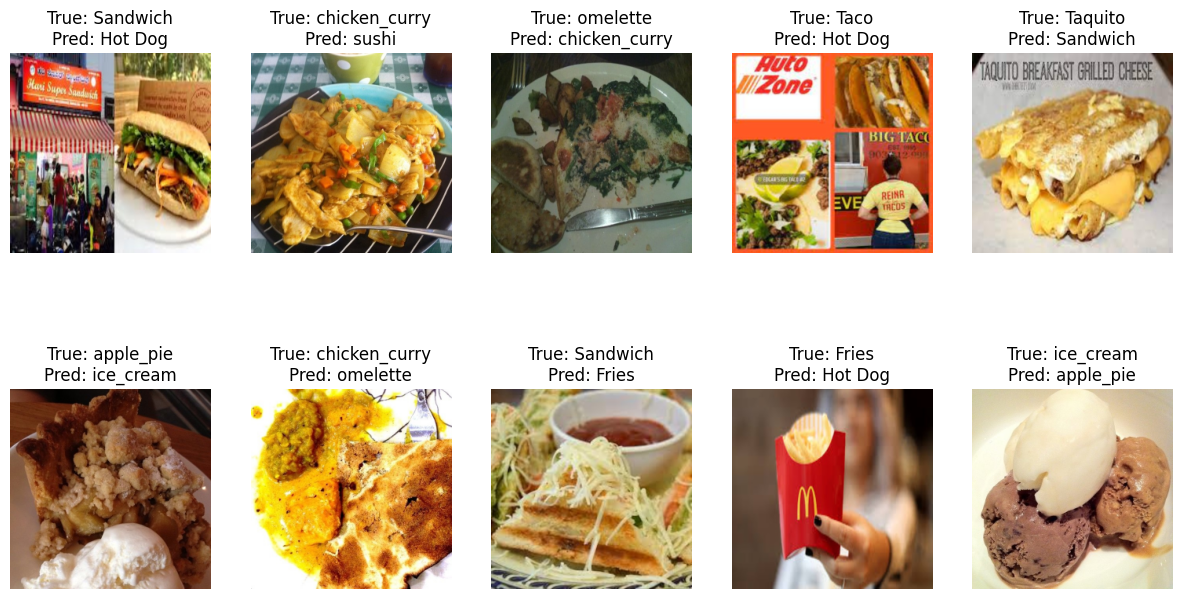

 
Training model vgg_no_dropout with SGD_1e-3 optimizer for 3 epochs


Train_epoch in progress: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]

Training Progress:  33%|███▎      | 1/3 [00:15<00:30, 15.07s/it]

Epoch 1/3, Train Loss: 2.6316, Val Loss: 2.6039, Val Acc: 0.1138



Train_epoch in progress: 100%|██████████| 28/28 [00:11<00:00,  2.34it/s]

Training Progress:  67%|██████▋   | 2/3 [00:30<00:15, 15.06s/it]

Epoch 2/3, Train Loss: 2.5928, Val Loss: 2.5643, Val Acc: 0.1674



Training Progress:  67%|██████▋   | 2/3 [00:40<00:20, 20.16s/it]


KeyboardInterrupt: 

In [ ]:


# Comparatore dei modelli (plot loss e accuracy)
comparer = ModelComparator("Experiments Comparison")

early_stopping = EarlyStopping(patience=5, min_delta=0)


training_summaries = []
for model_name,model_fn in models.items():
    training_logger = ExperimentLogger()
    for opt_name, opt_fn in optimizers.items():
        for epochs in epoch_list:
            experiment = f"\033[1;31m \nTraining model {model_name} with {opt_name} optimizer for {epochs} epochs\033[0m"
            print(experiment)

            model = model_fn()

            # Congela il backbone
            model.freeze_backbone()

            trainer = Trainer(
                model=model,
                name=model_name,
                criterion=criterion,
                device=device,
                train_loader=trainloader,
                val_loader=valloader,
                classes=classes,
                logger = training_logger
            )
            trainer.set_early_stopping(early_stopping)




            # Imposta optimizer
            optimizer = opt_fn(model)
            trainer.set_optimizer(optimizer,opt_name)

            # Add model to comparer
            key = comparer.add_model(model_name, opt_name,epochs)
            # Train
            train_losses, val_losses, val_accuracies,epochs_run, best_epoch = trainer.train(epochs=epochs)
            final_test_accuracy = trainer.final_test_accuracy(testloader)



            # add results to comparer
            comparer.results_model(key, train_losses, val_losses, val_accuracies, epochs_run, best_epoch)

            # Stampa info training
            info = trainer.get_last_training_info()
            training_summaries.append({
                    "experiment": experiment,
                    "summary": info
                })
            àccuracy_plot = trainer.plot_confusion_matrix(test_loader= testloader)




            print("-"*50)
            print("Visualizzazione degli errori commessi dal modello sul test set:")
            print("- Verranno mostrati esempi di immagini mal classificate,")
            print("  insieme alla loro classe predetta e alla classe reale.")
            print("- Questo aiuta a comprendere i casi in cui il modello fatica,")
            print("  evidenziando possibili pattern o ambiguità nei dati.")
            print("- Utile per analisi qualitative e miglioramento del modello.\n")
            # Mostra errori (10 immagini sbagliate)
            trainer.show_errors(test_loader= testloader)




    print("-" * 100)

    print("\n\n \033[1mGrafici di performance relativi ai singoli modelli sui vari ottimizzatori/regolarizzazioni\033[0m")
    print("\033[91mQuesti grafici mostrano l'andamento delle metriche di training e validazione,\n"
      "come la loss e l'accuratezza, per ogni combinazione di modello e ottimizzatore.\033[0m \n\n")
    print("-" * 100)

    trainer.plot_accuracies()
    trainer.plot_losses_bar()




**ANALISI RISULTATI**


    | Modello             | Ottimizz.   | Epoche | Val Acc | Val Loss | Train Loss |
    | resnet              | Adam_1e-3   | 20     | 0.8147  | 0.63   | 0.29     |
    | resnet              | Adam_1e-3   | 40     | 0.8125  | 0.56   | 0.13     |
    | resnet              | Adam_1e-3   | 44     | 0.8058  | 0.55   | 0.12     |
    | vgg_0.3drop_1024    | Adam_1e-3   | 15     | 0.7835  | 0.64   | 0.25     |
    | vgg_no_dropout      | Adam_1e-3   | 9      | 0.7812  | 0.65   | 0.15     |
    | vgg_no_dropout      | Adam_1e-3   | 19     | 0.7812  | 0.66   | 0.21     |
    | vgg_0_5drop_1024    | Adam_1e-3   | 18     | 0.7790  | 0.62   | 0.25     |
    | vgg_0.3drop_512     | Adam_1e-3   | 9      | 0.7746  | 0.66   | 0.22     |
    | resnet              | SGD_1e-3    | 40     | 0.7411  | 0.128  | 0.104    |
    | squeezenet          | SGD_1e-3    | 40     | 0.7277  | 0.80   | 0.32     |
    | resnet              | SGD_1e-3    | 20     | 0.7098  | 0.163  | 0.140    |

Dall'analisi dei risultati ottenuti durante gli esperimenti, emerge con chiarezza che la combinazione tra ResNet e l’ottimizzatore Adam è quella che ha garantito le performance migliori sia in termini di accuratezza che di capacità di generalizzazione. ResNet, grazie alla sua struttura con connessioni residue, si è dimostrato un modello particolarmente efficace nell’apprendere le caratteristiche salienti del dataset, mentre l'ottimizatore Adam ha contribuito con la sua efficienza nell’ottimizzazione, portando rapidamente alla convergenza e mantenendo valori di loss molto bassi.

Anche le varianti del modello VGG dotate di dropout hanno mostrato un buon comportamento. Tuttavia, rispetto a ResNet, queste architetture si sono rivelate più sensibili alla scelta dell’ottimizzatore e del numero di epoche: senza un attento tuning, i risultati tendono a variare maggiormente, e la rete può facilmente incorrere in overfitting o underfitting.


**LOGGING**

La classe Trainer organizza e salva i dati di training, come loss e accuracy per ogni epoca, mantenendoli in una lista di esperimenti. Ogni esperimento può essere esportato in un file JSON per una registrazione persistente. Inoltre, il modello viene salvato automaticamente in una cartella dedicata con struttura ordinata, facilitando il caricamento e la gestione. Questa gestione integrata supporta il confronto tra modelli, ottimizzatori e configurazioni diverse, garantendo tracciabilità e riproducibilità degli esperimenti.








**ANALISI ERRORI**

Anche con un’accuracy tra 75% e 85%, il modello tende a commettere errori su classi che presentano caratteristiche visive simili o elementi comuni. Per esempio, confonde spesso piatti come ice cream e apple pie, cheesecake e apple pie, oppure omelette con sushi o chicken curry. Questi errori avvengono perché i colori, le texture o le forme degli alimenti possono essere molto simili, rendendo difficile per il modello discriminare con precisione.

Allo stesso modo, piatti come taquito e baked potato o fries con hot dog e sandwiches vengono confusi tra loro, probabilmente a causa della presenza di elementi ripetitivi come patatine fritte o la forma allungata di certi cibi. Questi casi mostrano come il modello fatichi quando le differenze visive sono sottili o quando ci sono sovrapposizioni tra le caratteristiche delle classi.
Ancor di più tali caratteristiche si enfatizzano quando si hanno alcuni elementi comuni nel settore food quali piatti e ciotole, quasi sempre presenti in primi piatti
In generale, questi errori evidenziano i limiti di un modello che apprende solo da immagini senza informazioni aggiuntive, come ingredienti o contesto, e sottolineano l’importanza di un dataset ben bilanciato e magari l’uso di tecniche che aiutino a enfatizzare le differenze tra classi simili.

**CONCLUSIONE**

In questo esperimento di classificazione di immagini food su 14 classi, con un dataset ridotto a circa 1000 immagini, i risultati mostrano che il modello ResNet ha ottenuto la migliore accuratezza di validazione, intorno all’81%. I modelli VGG, con o senza dropout, si sono attestati tra il 77% e il 78%, mentre MobileNet e SqueezeNet hanno ottenuto risultati leggermente inferiori, tra il 70% e il 76%. Considerando la quantità limitata di dati, queste performance possono essere considerate soddisfacenti e indicano che i modelli sono riusciti a cogliere pattern significativi. Tuttavia, per migliorare ulteriormente le metriche sarebbe importante addestrare i modelli su un dataset più completo e soprattutto ottimizzare meglio gli iperparametri. Questi passi potrebbero aumentare la robustezza e l’affidabilità dei modelli, avvicinandoli a prestazioni più elevate necessarie per applicazioni reali.

In [ ]:


print("\n\n\033[1mRiepilogo Esperimenti:\033[0m")
for summary in training_summaries:
    print(summary["experiment"])
    print("="*50)
    print(f"Optimizer:           {summary['summary'].get('optimizer', 'N/A')}")
    print(f"Criterion:           {summary['summary'].get('criterion', 'N/A')}")
    print(f"Epochs Run:          {summary['summary'].get('epochs_run', 'N/A')}")
    print(f"best_epoch_early_stopping: {summary['summary'].get('best_epoch_early_stopping', 'N/A')}")
    print("-"*50)
    print(f"Final Training Loss: {summary['summary']['train_losses'][-1]:.4f}")
    print(f"Final Validation Loss: {summary['summary']['val_losses'][-1]:.4f}")
    print(f"Final Validation Accuracy: {summary['summary']['final_accuracy']:.4f}")
    print("="*50)




**ANALISI PERFORMANCE**
- Impatto degli Ottimizzatori
-- L’ottimizzatore Adam ha dimostrato superiorità in tutti i modelli, con convergenza rapida e valori di loss molto contenuti già nelle prime 10–20 epoche. Questo ha permesso l’utilizzo efficace dell’early stopping, bloccando l’addestramento al momento opportuno.
Al contrario, l’ottimizzatore SGD ha portato a risultati decisamente inferiori. Le accuracy sono state mediamente più basse (massimo ~74% con ResNet) e i valori di loss significativamente più alti. Inoltre, l’assenza di early stopping nei modelli con SGD suggerisce una curva di apprendimento più lenta e meno efficiente, forse migliorabile con ottimizzazione del learning rate o momentum.
- Numero di Epoche
-- La maggior parte dei modelli ha mostrato convergenza entro le prime 20 epoche. Adam ha permesso di ottenere buoni risultati rapidamente, mentre con SGD è stato necessario spingersi fino a 40 epoche per ottenere un comportamento accettabile. Tuttavia, aumentare troppo le epoche senza regolarizzazione ha portato raramente a miglioramenti significativi, e in alcuni casi ha causato un leggero peggioramento dovuto ad overfitting.

Inoltre durante l’addestramento di SqueezeNet con SGD, si nota un particolarità relativa ad una discesa molto rapida della loss nelle prime epoche, seguita da un rallentamento marcato. Al contrario, modelli come ResNet o VGG mostrano una perdita che cala in modo più lineare e costante.

Una possibile spiegazione è che SqueezeNet, essendo molto compatto, apprende velocemente pattern semplici, ma la sua capacità limitata lo porta presto a saturarsi. Inoltre, SGD, privo di adattività, favorisce grandi miglioramenti iniziali ma non riesce ad affinare il modello in maniera efficace nelle fasi successive.

In [ ]:
comparer.plot_loss_train()
comparer.plot_loss_validate()
comparer.plot_accuracy()